In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv("store_forecasting_data (1) (1)/store_forecasting_data/train.csv", parse_dates=["date"])
test = pd.read_csv("store_forecasting_data (1) (1)/store_forecasting_data/test.csv", parse_dates=["date"])
stores = pd.read_csv("store_forecasting_data (1) (1)/store_forecasting_data/stores.csv")
oil = pd.read_csv("store_forecasting_data (1) (1)/store_forecasting_data/oil.csv", parse_dates=["date"])
holidays = pd.read_csv("store_forecasting_data (1) (1)/store_forecasting_data/holidays_events.csv", parse_dates=["date"])

In [ ]:
#checking for null values and use nterpolate to make it up 

In [5]:
oil['dcoilwtico'].isnull().sum()

43

In [7]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()

In [9]:
oil['dcoilwtico'].isnull().sum()

1

In [ ]:
#As interpolate cannot fill for first values as it require before and after values so we are make the particular recor value to backward fill

In [11]:
oil['dcoilwtico'].fillna(method='bfill', inplace=True)

C:\Users\SRI SATHISH KUMAR J\AppData\Local\Temp\ipykernel_15644\1165887010.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  oil['dcoilwtico'].fillna(method='bfill', inplace=True)
C:\Users\SRI SATHISH KUMAR J\AppData\Local\Temp\ipykernel_15644\1165887010.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  oil['dcoilwtico'].fillna(method='bfill', inplace=True)


In [ ]:
# here we are combine multiple dataframe into single using a common columns with left join

In [13]:
train = train.merge(stores, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(holidays, on='date', how='left', suffixes=('', '_holiday'))

In [ ]:
# here we are creating a feature which related to time and to divide manipulate the records easily for further process

In [15]:
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week.astype(int)
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek
train['is_weekend'] = train['day_of_week'].isin([5, 6])
train['is_payday'] = train['day'].isin([15, 31])
train['is_earthquake'] = (train['date'] == pd.to_datetime("2016-04-16")).astype(int)

In [17]:
train['is_holiday'] = train['type'].isin(['Holiday', 'Transfer', 'Additional']).astype(int)
train['is_event'] = train['type'].isin(['Event']).astype(int)
train['is_promotion'] = train['transferred'].map({True: 1, False: 0})
economic_keywords = ['Black Friday', 'Cyber Monday', 'Back to School']
train['is_economic_event'] = train['description'].fillna('').apply(lambda x: any(k in x for k in economic_keywords)).astype(int)


In [19]:
train = train.sort_values(['store_nbr', 'family', 'date'])
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['sales_lag_30'] = train.groupby(['store_nbr', 'family'])['sales'].shift(30)
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).mean()
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(7).std()

In [21]:
store_type_avg = train.groupby('type', as_index=False)['sales'].mean().rename(columns={'sales': 'avg_sales_by_type'})
train = train.merge(store_type_avg, on='type', how='left')


In [ ]:
# store_type_avg indicate that the sale for the each type and their average sales

In [23]:
store_type_avg

,type,avg_sales_by_type
0,A,708.378165
1,B,328.275233
2,C,197.790647
3,D,352.084510
4,E,270.285490


In [25]:
top_families = train.groupby(['cluster', 'family'])['sales'].sum().reset_index()
top_families = top_families.sort_values(['cluster', 'sales'], ascending=[True, False])
top_families = top_families.groupby('cluster').head(3)
top_families['top_family_flag'] = 1
train = train.merge(top_families[['cluster', 'family', 'top_family_flag']], on=['cluster', 'family'], how='left')
train['top_family_flag'] = train['top_family_flag'].fillna(0).astype(int)

In [ ]:
# here we are top three family from each cluster and indicate to our model that they are the once higher sales value so we flag them as 1

In [71]:
top_families

,cluster,family,sales,top_family_flag
12,1,GROCERY I,1.483284e+07,1
3,1,BEVERAGES,1.201252e+07,1
30,1,PRODUCE,8.221406e+06,1
45,2,GROCERY I,8.649030e+06,1
36,2,BEVERAGES,5.503139e+06,1
63,2,PRODUCE,5.068959e+06,1
78,3,GROCERY I,2.978610e+07,1
69,3,BEVERAGES,1.495938e+07,1
73,3,CLEANING,1.010321e+07,1
111,4,GROCERY I,1.682519e+07,1


In [ ]:
#these are the features used for the model 

In [27]:
features = [
    'day', 'week', 'month', 'year', 'day_of_week', 'is_weekend', 'is_payday',
    'dcoilwtico', 'sales_lag_7', 'sales_lag_30', 'rolling_mean_7', 'rolling_std_7',
    'is_holiday', 'is_event', 'is_promotion', 'is_earthquake', 'is_economic_event',
    'avg_sales_by_type', 'top_family_flag'
]

In [ ]:
# train test split has been done here XGB model has been defined here

In [29]:
train_model = train.dropna(subset=features + ['sales'])
X = train_model[features]
y = train_model['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

xgb_model = XGBRegressor(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [ ]:
# likewise random forest

In [59]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, random_state=42)

In [ ]:
# to find best parameter for (P,d,q) 

In [73]:
from pmdarima import auto_arima

auto_model = auto_arima(train_ts, seasonal=False, trace=True)
print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=45770.047, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=46452.722, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=46335.004, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=45967.915, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=46450.728, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=45791.748, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=45817.458, Time=0.37 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=45782.605, Time=1.11 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=45509.879, Time=2.20 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=45799.492, Time=0.62 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=45498.325, Time=2.52 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=45477.990, Time=2.92 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=45670.858, Time=2.54 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=45558.761, Time=1.82 sec
 ARIMA(4,1,4)(0,0,0

In [75]:
train_ts = train.groupby('date')['sales'].sum()
arima_model = ARIMA(train_ts, order=(4,1,3)).fit()
arima_forecast = arima_model.forecast(steps=len(y_val))

In [ ]:
# as we need to forecaste for nxt 15 days so we need to take 15 days from the last date from df train

In [31]:
last_date = train['date'].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=15)
store_family_combos = train[['store_nbr', 'family']].drop_duplicates()

forecast_df = pd.DataFrame([(row.store_nbr, row.family, date) for date in forecast_dates for _, row in store_family_combos.iterrows()],
                           columns=['store_nbr', 'family', 'date'])


In [33]:
forecast_df = forecast_df.merge(stores, on='store_nbr', how='left')
forecast_df = forecast_df.merge(oil, on='date', how='left')
forecast_df = forecast_df.merge(holidays, on='date', how='left', suffixes=('', '_holiday'))


In [35]:
forecast_df['day'] = forecast_df['date'].dt.day
forecast_df['week'] = forecast_df['date'].dt.isocalendar().week.astype(int)
forecast_df['month'] = forecast_df['date'].dt.month
forecast_df['year'] = forecast_df['date'].dt.year
forecast_df['day_of_week'] = forecast_df['date'].dt.dayofweek
forecast_df['is_weekend'] = forecast_df['day_of_week'].isin([5, 6])
forecast_df['is_payday'] = forecast_df['day'].isin([15, 31])
forecast_df['is_earthquake'] = (forecast_df['date'] == pd.to_datetime("2016-04-16")).astype(int)
forecast_df['is_holiday'] = forecast_df['type'].isin(['Holiday', 'Transfer', 'Additional']).astype(int)
forecast_df['is_event'] = forecast_df['type'].isin(['Event']).astype(int)
forecast_df['is_promotion'] = forecast_df['transferred'].map({True: 1, False: 0})
forecast_df['is_economic_event'] = forecast_df['description'].fillna('').apply(lambda x: any(k in x for k in economic_keywords)).astype(int)
forecast_df = forecast_df.merge(store_type_avg, on='type', how='left')
forecast_df = forecast_df.merge(top_families[['cluster', 'family', 'top_family_flag']], on=['cluster', 'family'], how='left')
forecast_df['top_family_flag'] = forecast_df['top_family_flag'].fillna(0).astype(int)


In [37]:
data_lags = train.groupby(['store_nbr', 'family'])[['sales_lag_7', 'sales_lag_30', 'rolling_mean_7', 'rolling_std_7']].last().reset_index()
forecast_df = forecast_df.merge(data_lags, on=['store_nbr', 'family'], how='left')

In [39]:
data_lags

,store_nbr,family,sales_lag_7,sales_lag_30,rolling_mean_7,rolling_std_7
0,1,AUTOMOTIVE,4.000,2.000,4.142857,3.287784
1,1,BABY CARE,0.000,0.000,0.000000,0.000000
2,1,BEAUTY,2.000,2.000,3.857143,3.236694
3,1,BEVERAGES,2418.000,1079.000,1825.000000,680.284989
4,1,BOOKS,0.000,0.000,0.000000,0.000000
...,...,...,...,...,...,...
1777,54,POULTRY,73.289,103.902,68.802571,16.501983
1778,54,PREPARED FOODS,86.000,50.000,87.285714,30.092714
1779,54,PRODUCE,790.013,981.712,655.629857,137.980355
1780,54,SCHOOL AND OFFICE SUPPLIES,0.000,0.000,0.000000,0.000000


In [41]:
forecast_df[features] = forecast_df[features].fillna(method='ffill').fillna(0)
X_forecast = forecast_df[features]
forecast_df['predicted_sales'] = xgb_model.predict(X_forecast)

C:\Users\SRI SATHISH KUMAR J\AppData\Local\Temp\ipykernel_15644\3415042530.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  forecast_df[features] = forecast_df[features].fillna(method='ffill').fillna(0)


In [43]:
forecast_result = forecast_df[['store_nbr', 'family', 'date', 'predicted_sales']]
print(forecast_result.head())

   store_nbr      family       date  predicted_sales
0          1  AUTOMOTIVE 2017-08-16         6.528314
1          1   BABY CARE 2017-08-16         4.718260
2          1      BEAUTY 2017-08-16         6.528314
3          1   BEVERAGES 2017-08-16      1799.947388
4          1       BOOKS 2017-08-16         4.718260


In [45]:
forecast_result

,store_nbr,family,date,predicted_sales
0,1,AUTOMOTIVE,2017-08-16,6.528314
1,1,BABY CARE,2017-08-16,4.718260
2,1,BEAUTY,2017-08-16,6.528314
3,1,BEVERAGES,2017-08-16,1799.947388
4,1,BOOKS,2017-08-16,4.718260
...,...,...,...,...
26725,54,POULTRY,2017-08-30,71.078430
26726,54,PREPARED FOODS,2017-08-30,93.592094
26727,54,PRODUCE,2017-08-30,720.759766
26728,54,SCHOOL AND OFFICE SUPPLIES,2017-08-30,3.429129


In [47]:
forecast_result.to_csv("forecast_15_day_output.csv", index=False)

In [ ]:
#Evaluation metric for each models

In [53]:
y_val_pred = xgb_model.predict(X_val)
print("\nXGBoost Model Evaluation:")
print("RMSE:", np.sqrt(mean_squared_error(y_val, y_val_pred)))
print("MAPE:", mean_absolute_percentage_error(y_val, y_val_pred))
print("R2 Score:", r2_score(y_val, y_val_pred))


XGBoost Model Evaluation:
RMSE: 648.4675773848704
MAPE: 1.3312163782970076e+16
R2 Score: 0.8667064415501349


In [63]:
print("\nRandom Forest Evaluation:")
rf_preds = rf_model.predict(X_val)
print("RMSE:", np.sqrt(mean_squared_error(y_val, rf_preds)))
print("MAPE:", mean_absolute_percentage_error(y_val, rf_preds))
print("R2:", r2_score(y_val, rf_preds))


Random Forest Evaluation:
RMSE: 657.4028511424151
MAPE: 1.9129762484928492e+16
R2: 0.8630078141816704


In [77]:
print("\nARIMA Evaluation (aggregated sales):")
y_val_agg = y_val.groupby(y_val.index).sum()
print("RMSE:", np.sqrt(mean_squared_error(y_val_agg[:len(arima_forecast)], arima_forecast)))


ARIMA Evaluation (aggregated sales):
RMSE: 791567.295141939


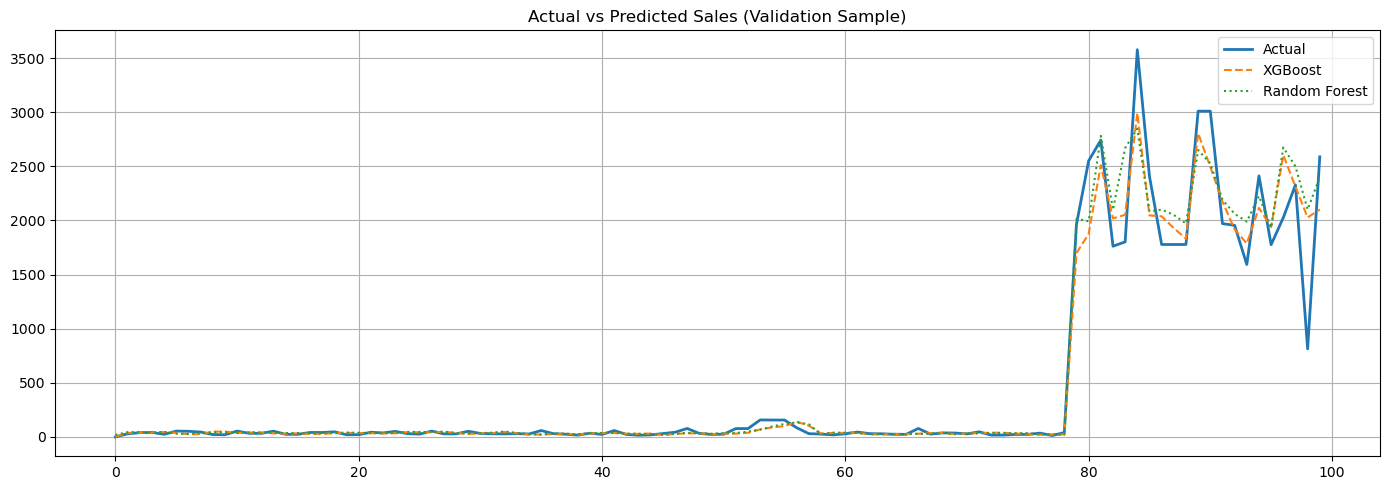

In [69]:
plt.figure(figsize=(14, 5))
plt.plot(y_val.values[:100], label='Actual', linewidth=2)
plt.plot(y_val_pred[:100], label='XGBoost', linestyle='--')
plt.plot(rf_preds[:100], label='Random Forest', linestyle=':')
plt.legend()
plt.title("Actual vs Predicted Sales (Validation Sample)")
plt.grid(True)
plt.tight_layout()
plt.show()